# 3 Red Cards Study

In [48]:
# imports
import sklearn
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os

## 3.1 Loading and Cleaning the Data

In [ ]:
# load data
filename = 'data\CrowdstormingDataJuly1st.csv'
print(filename)
df = pd.read_csv(filename)
print(df.columns)
print(df.info)

In [ ]:
# test data access
df[df['playerShort']=='mesut-oezil']['refNum'][:4] # all referees in games with mesut oezil

In [ ]:
# data cleaning

# drop players without skin color rating
df = df.dropna(subset=['rater1','rater2'])

Text(0.5, 1.0, 'Frequent referees')

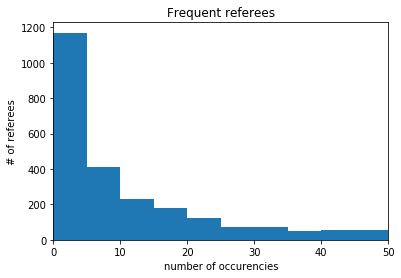

In [107]:
# plot referee occurencies
refnum_unique = np.unique(df['refNum'],return_counts=True,return_index=True)
plt.hist(refnum_unique[2],bins=np.arange(100)*5)
plt.xlim(0,50)
plt.xlabel('number of occurencies')
plt.ylabel('# of referees')
plt.title('Frequent referees')

There is a large number of referees, who appear less then ten times in the data set. This is especially troubeling as we would expect a referee who leads one game in the one of the studied leagues to appear at least 22 times - one time in combination with each player of the two teams. We thus exclude all referees with less than 22 occurencies.

In [109]:
#exclude referees with less than 22 occurencies

df = df[[rn not in refnum_unique[0][np.where(refnum_unique[2]<22)[0]] for rn in df['refNum']]]

In [110]:
# new features
occurencies = [[df['playerShort']==player] for player in np.unique(df['playerShort'])]
dfage = 2013 - np.array([int(b[-4:]) for b in df['birthday'].values]) # age at the end of the season in years
age = dfage[np.unique(df['playerShort'],return_index=True)[1]]
totalRedCards = np.array([np.sum(df[occ[0]]['redCards']) for occ in occurencies])
totalGames =   np.array([np.sum(df[occ[0]]['games']) for occ in occurencies])
averageRedCards = totalRedCards/totalGames

# drop uninteresting features
df = df.drop(['club','height', 'birthday', 'weight',
       'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'photoID', 
       'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],axis=1)

df.shape

(112484, 9)

Text(0, 0.5, 'red cards per game')

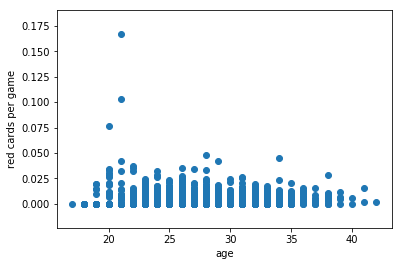

In [112]:
plt.scatter(age,averageRedCards)
plt.xlabel('age')
plt.ylabel('red cards per game')

Text(0.5, 1.0, 'skin color ratings')

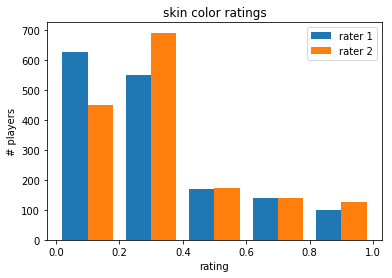

In [114]:
# visualise skin color ratings

# rater 1
rat1 = df.iloc[np.unique(df['playerShort'],return_index=True)[1]]['rater1']

# rater 2
rat2 = df.iloc[np.unique(df['playerShort'],return_index=True)[1]]['rater2']

plt.hist([rat1,rat2],bins=5)
plt.legend(['rater 1','rater 2'])
plt.xlabel('rating')
plt.ylabel('# players')
plt.title('skin color ratings')

We observe that the raters asign different numbers of players to the skin color classes. There are also much more players with very light or light skin color than players with dark or very dark skin color. 

Rater 2 assignes lighter skin color more often than rater 1.

[-0.5  -0.25  0.    0.25]
mean difference: -0.04182449494949495
std difference: 0.11593827601116938


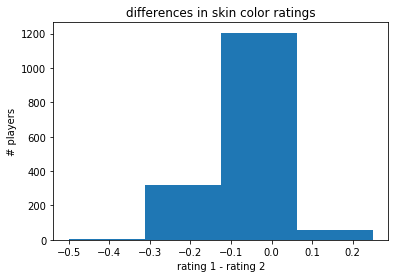

In [115]:
# differences in color ratings
diffrat = rat1 - rat2 
print(np.unique(diffrat))
plt.hist(diffrat,bins=4) 
plt.xlabel('rating 1 - rating 2')
plt.ylabel('# players')
plt.title('differences in skin color ratings')

print('mean difference:', np.mean(diffrat))
print('std difference:', np.std(diffrat))

Rater 2 assignes lighter skin color more often than rater 1. The standard deviation of the differences is roughly half the size of the difference between to neighbouring skin tones. Excluding data where the diffence is large will improve the accuracy of our analysis. Alternatively, we could take the mean between the both ratings.

9


Text(0.5, 1.0, 'mean of skin color ratings')

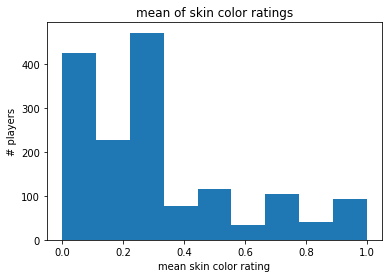

In [116]:
# mean color ratings
meanrat = 0.5*(rat1 + rat2)
print(len(np.unique(meanrat)))
plt.hist(meanrat,bins=9) 
plt.xlabel('mean skin color rating')
plt.ylabel('# players')
plt.title('mean of skin color ratings')

1205


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'mean of skin color ratings')

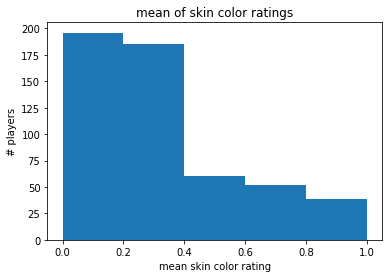

In [123]:
# mean color ratings
ratboth = rat1[np.where(rat1==rat2)[0]]
print(len(ratboth))
plt.hist(ratboth,bins=5) 
plt.xlabel('mean skin color rating')
plt.ylabel('# players')
plt.title('mean of skin color ratings')

Text(0, 0.5, 'red cards per game')

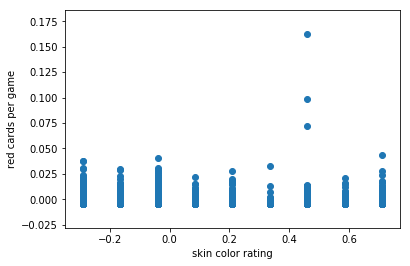

In [129]:
plt.scatter(meanrat,averageRedCards)
plt.xlabel('skin color rating')
plt.ylabel('red cards per game')

In [128]:
# centralize features
age = age - np.mean(age)
meanrat = meanrat - np.mean(meanrat)
averageRedCards = averageRedCards - np.mean(averageRedCards)

## 3.2 Model Creation

### Linear Regression

In [402]:
# linear regression
def linreg(x,y):
    A0 = (np.arange(1e3)-0.5e3)*1e6
    a = 0
    err = np.pi
    errs=[]
    n = 0
    converge = False
    while err > 1e-4 and n < 100 and converge == False:
        A = a+A0*(1e-3)**n
        Err = np.sum(([x*A[i] for i in range(len(A))]-y)**2,axis=1)
        imin = np.argmin(Err)
        err = Err[imin]
        errs.append(err)
        a = A[imin]
        n += 1
        if len(errs) > 10 and (np.abs(errs[n-1]-np.mean(errs[-10:-1]))) < np.std(errs[-10:-1]):
            converge = True
    #plt.scatter(range(len(errs)),errs)
    
    return a,err

In [403]:
x = np.arange(10)

y = np.pi*x
print(linreg(x,y))

(3.142, 4.7290362903884606e-05, 4)


In [418]:
def lr_error_range(arr,a,err):
    P = mpl.patches.Polygon([[np.min(arr),np.min(arr)*a-err],[np.min(arr),np.min(arr)*a+err],[np.max(arr),np.max(arr)*a+err],[np.max(arr),np.max(arr)*a-err]],alpha=0.1,color='r')
    return P

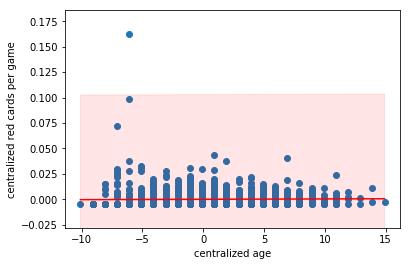

In [420]:
lr_age = linreg(age,averageRedCards)

plt.scatter(age,averageRedCards)
plt.xlabel('centralized age')
plt.ylabel('centralized red cards per game')
plt.plot([np.min(age),np.max(age)],[np.min(age)*lr_age[0],np.max(age)*lr_age[0]],color='r')

P = lr_error_range(age,lr_age[0],lr_age[1])
plt.gca().add_patch(P)

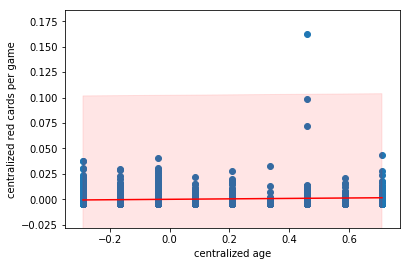

In [419]:
lr_rat = linreg(meanrat,averageRedCards)

plt.scatter(meanrat,averageRedCards)
plt.xlabel('centralized age')
plt.ylabel('centralized red cards per game')
plt.plot([np.min(meanrat),np.max(meanrat)],[np.min(meanrat)*lr_rat[0],np.max(meanrat)*lr_rat[0]],color='r')

P = lr_error_range(meanrat,lr_rat[0],lr_rat[1])
plt.gca().add_patch(P)

In [ ]:
def lr_error_range(arr,a,err):
    P = mpl.patches.Polygon([[np.min(arr),np.min(arr)*a-err],[np.min(arr),np.min(arr)*a+err],[np.max(arr),np.max(arr)*a+err],[np.max(arr),np.max(arr)*a-err]],alpha=0.1,color='r')
    return P
    
P = lr_error_range(meanrat,lr_rat[0],lr_rat[1])

### Regression Forest

In [ ]:
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
class RegressionTree(Tree):
    def __init__(self):
        super(RegressionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):

        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        #put root in stack
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                
                perm = np.random.permutation(D)   # permute D indices
                left, right = make_regression_split_node(node, perm[:D_try]) #select :D_try of permuted indices
                                                       #for 'make_decision_split_node()'
                # put children in stack
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_regression_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return leaf.response 
    


def make_regression_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = 1e100
    j_min, t_min = 0, 0
    for j in feature_indices:
        # remove duplicate features
        dj = np.sort(np.unique(node.data[:,j]))
        # compute candidate thresholds in the middle between consecutive feature values
        tj = 0.5 * (dj[1:] + dj[:-1]) 
        # each candidate threshold we need to compute Gini impurities of the resulting children node
        for t in tj:
            left_indices = node.data[:,j] <= t
            nl = np.sum(left_indices)
            ll = node.labels[left_indices]
            el = np.sum((ll-np.mean(ll))**2)
            nr = n - nl
            lr = node.labels[node.data[:,j] > t]
            er = np.sum((lr-np.mean(lr))**2)
            # choose the the best threshold that minimizes sum of Gini impurities
            if el + er < e_min:
                e_min = el + er
                j_min = j
                t_min = t


    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] <= t_min, :]
    left.labels = node.labels[node.data[:,j_min] <= t_min]
    right.data = node.data[node.data[:,j_min] > t_min, :]
    right.labels = node.labels[node.data[:,j_min] > t_min]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right    

def make_regression_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    node.N = node.labels.shape[0]
    node.response = np.mean(node.labels) / node.N
    
    
class RegressionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [RegressionTree() for i in range(n_trees)]
    
    def train(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bootstrap = np.random.choice(len(data), size=len(data))
            tree.train(data[bootstrap], labels[bootstrap], n_min)

    def predict(self, x):
        # compute the ensemble prediction
        return np.mean([tree.predict(x) for tree in self.trees], axis=0)

In [ ]:
#traing a discriminative classifier using one instance of RegressionForest
df = RegressionForest(20)
df.train(np.array([age,meanrat]).T, averageRedCards, 20)

In [435]:
np.array([age,meanrat]).T

array([[ 6.90151515, -0.16453598],
       [-0.09848485, -0.16453598],
       [-1.09848485, -0.03953598],
       ...,
       [ 6.90151515,  0.58546402],
       [ 1.90151515, -0.28953598],
       [-0.09848485, -0.28953598]])